In [434]:
import pandas as pd
import numpy as np


##########################################################################################################
# Assumptions and approximations:
# - the campaign uplift is the same cross (platform x kitchen). platform is a strong assumption.
# - the weekly order is equally distributed.
# - the seasonablity is extracted from Kungholmen 2021.
# - the concept porfolio is using the June setting.
# - Baseline: week 24, date 13-19. Core principle: pick a week without campaign and the sales are low
##########################################################################################################



# base = {'kungsholmen': {'curb': 382, 'el burro':  93, 'macka': 103, 'wings':  49, 'sumak kebab': 76, 'pizza': 37, 'candie': 67},
#         'arsta':       {'curb': 423, 'el burro': 200, 'macka': 127, 'wings':  56, 'sumak kebab': 64, 'pizza': 29, 'candie': 49},
#         'nordvest':    {'curb': 314, 'el burro': 190, 'macka':  66, 'wings':  61, 'sumak kebab': 35, 'pizza': 59, 'candie': 19},
#         'uppsala':     {'curb': 186, 'el burro':  97, 'macka':  14, 'wings':  35, 'sumak kebab': 32, 'pizza': 33, 'candie':  0},
#         'morby':       {'curb': 129, 'el burro':  43, 'macka':  21, 'wings':  11, 'sumak kebab': 23, 'pizza': 16, 'candie':  0},
#         'helsingborg': {'curb':  20, 'el burro':  54, 'macka':   9, 'wings':  11, 'sumak kebab':  8, 'pizza':  3, 'candie':  0},
#        }


# base = {'kungsholmen': {'curb': 808},
#         'arsta':       {'curb': 996},
#         'nordvest':    {'curb': 713},
#         'uppsala':     {'curb': 419},
#         'morby':       {'curb': 252},
#         'helsingborg': {'curb': 105},
#        }

# positive
base = {'kungsholmen': {'curb': 850},
        'arsta':       {'curb': 850},
        'nordvest':    {'curb': 700}, # Add just eat
#         'nordvest':    {'curb': 560},
        'uppsala':     {'curb': 380},
        'morby':       {'curb': 200},
        'helsingborg': {'curb': 120},
       }


# # conservtive 
# base = {'kungsholmen': {'curb': 800},
#         'arsta':       {'curb': 800},
#         'nordvest':    {'curb': 520},
#         'uppsala':     {'curb': 350},
#         'morby':       {'curb': 200},
#         'helsingborg': {'curb': 110},
#        }



# Old
# targets = {
#            7: {'kungsholmen': 3500,
#                'arsta': 3500,
#                'nordvest': 2000,
#                'uppsala': 1200,
#                'morby': 500,
#                'helsingborg': 300
#                },
#            8: {'kungsholmen': 4000,
#                 'arsta': 4000,
#                 'nordvest': 2300,
#                 'uppsala': 1380,
#                 'morby': 575,
#                 'helsingborg': 500
#               },
#            9: {'kungsholmen': 4800,
#                 'arsta': 4800,
#                 'nordvest': 3000,
#                 'uppsala': 1587,
#                 'morby': 661,
#                 'helsingborg': 661
#               },
#           }


# New
targets = {
           7: {'kungsholmen': 3500,
               'arsta': 3500,
               'nordvest': 2700,
               'uppsala': 1500,
               'morby': 900,
               'helsingborg': 400
               },
           8: {'kungsholmen': 4000,
                'arsta': 4000,
                'nordvest': 3500,
                'uppsala': 1500,
                'morby': 1000,
                'helsingborg': 500
              },
           9: {'kungsholmen': 4500,
                'arsta': 4500,
                'nordvest': 3800,
                'uppsala': 2000,
                'morby': 1000,
                'helsingborg': 600
              },
          }



# 300 dishes every day for kungsholmen and arsta
n_dish_per_order = 2
# n_dish_per_order = 1.5


seasonality_pct = {7: -0.17,
                   8: -0.10,
                   9: 0.00}

# # Best guess
# seasonality_pct = {7: -0.17,
#                    8: -0.10,
#                    9: 0.0}

weekly_distribution = np.array([0.25, 0.25, 0.25, 0.25])
daily_distribution = np.array([0.1198, 0.123, 0.1253, 0.131, 0.1515, 0.1717, 0.1777])


##############
# Finding from uber
# Order uplift: ~ 4 or 5
# CR uplift: 2.7

# Only Kungs or Arsta: 1110/800
# Both: 2241/1855

# The total uplift is around 1.2 or 1.3
uplift = 1.4


solution_space = [
    [0, 0, 0, 0],
    [1, 0, 0, 0],
    [1, 1, 0, 0],
    [1, 1, 1, 0],
    [1, 1, 1, 1],
    ]


In [435]:
data = []
for m in range(7, 10):
    for i in base.items():
        kitchen = i[0]
        concepts = i[1]
        target = targets[m][kitchen]
        counter = 0
        projected_orders = 0
        projected_daily_orders = []
        if kitchen in ['kungsholmen', 'arsta']:
            print(f'Month {m} - {kitchen}')
            print(f'Target: {target}')
            while projected_orders < target and counter < len(solution_space):
                projected_orders = 0
                solution = solution_space[counter]
                projected_weekly_orders = [0, 0, 0, 0]
                for c in concepts.items():
                    base_orders = c[1] * (30/7) # convert from weekly to monthly
#                     print(f'Base orders: {base_orders}')
                    base_orders_adj = base_orders * (1 + seasonality_pct[m])
#                     print(f'Base orders (adj): {base_orders_adj}')
                    weekly_orders = base_orders_adj * weekly_distribution
#                     print(f'Weekly orders: {weekly_orders}')
#                     if c[0] == 'curb':
                    weekly_orders = weekly_orders + weekly_orders * solution * (uplift - 1)
#                     print(f'Weekly orders with campaign: {weekly_orders}')
#                     print('#############')
    
                    projected_weekly_orders += weekly_orders
                    projected_orders += weekly_orders.sum()
                
                counter += 1
            projected_daily_orders.append([(wi * daily_distribution).astype(int) for wi in projected_weekly_orders])
            
            
            if projected_orders >= target:
#                 print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
                print(f'Projected orders: {int(projected_orders)}')
                print(f'Feasible campaign schema: {solution}')
                data.append([m, kitchen, target, int(projected_orders), projected_weekly_orders.astype(int), projected_daily_orders,  solution])
            else:
                print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Infeasible solution!')
                data.append([m, kitchen, target, int(projected_orders), projected_weekly_orders.astype(int), projected_daily_orders, 'infeasible'])
            print('--------------------------------------------')
        else:
            print(f'Month {m} - {kitchen}')
            print(f'Target: {target}')
            print('@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,')
            print(solution)
            print('@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,')
            projected_orders = 0
            projected_weekly_orders = [0, 0, 0, 0]
            for c in concepts.items():
                base_orders = c[1] * (30/7) # convert from weekly to monthly
#                 print(f'Base orders: {base_orders}')
                base_orders_adj = base_orders * (1 + seasonality_pct[m])
#                 print(f'Base orders (adj): {base_orders_adj}')
                weekly_orders = base_orders_adj * weekly_distribution
#                 print(f'Weekly orders: {weekly_orders}')
#                 if c[0] == 'curb':
                weekly_orders = weekly_orders + weekly_orders * solution * (uplift - 1)
#                 print(f'Weekly orders with campaign: {weekly_orders}')
#                 print('#############')
    
                projected_weekly_orders += weekly_orders
                projected_orders += weekly_orders.sum()
                
            projected_daily_orders.append([(wi * daily_distribution).astype(int) for wi in projected_weekly_orders])
            
            
            if projected_orders >= target:
#                 print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
                print(f'Projected orders: {int(projected_orders)}')
                print(f'Feasible campaign schema: {solution}')
                data.append([m, kitchen, target, int(projected_orders), projected_weekly_orders.astype(int), projected_daily_orders,  solution])
            else:
                print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Infeasible solution!')
                data.append([m, kitchen, target, int(projected_orders), projected_weekly_orders.astype(int), projected_daily_orders, 'infeasible'])
            print('--------------------------------------------')
        

Month 7 - kungsholmen
Target: 3500
Projected orders: 3628
Feasible campaign schema: [1, 1, 0, 0]
--------------------------------------------
Month 7 - arsta
Target: 3500
Projected orders: 3628
Feasible campaign schema: [1, 1, 0, 0]
--------------------------------------------
Month 7 - nordvest
Target: 2700
@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,
[1, 1, 0, 0]
@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,
Projected orders: 2988
Feasible campaign schema: [1, 1, 0, 0]
--------------------------------------------
Month 7 - uppsala
Target: 1500
@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,
[1, 1, 0, 0]
@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,
Projected orders: 1622
Feasible campaign schema: [1, 1, 0, 0]
--------------------------------------------
Month 7 - morby
Target: 900
@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,
[1, 1, 0, 0]
@@@@@@@@@@@@@@@@@@@@Warning, Warning, Warning,
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Infeasible solution!
----------

In [436]:
df = pd.DataFrame.from_records(data)

cols = ['month', 'kitchen', 'monthly_target_orders', 'monthly_projected_orders', 'Weekly_projected_orders', 'Daily_projected_orders', 'campaign_schema']
df.columns = cols
df

,month,kitchen,monthly_target_orders,monthly_projected_orders,Weekly_projected_orders,Daily_projected_orders,campaign_schema
0,7,kungsholmen,3500,3628,"[1058, 1058, 755, 755]","[[[126, 130, 132, 138, 160, 181, 188], [126, 1...","[1, 1, 0, 0]"
1,7,arsta,3500,3628,"[1058, 1058, 755, 755]","[[[126, 130, 132, 138, 160, 181, 188], [126, 1...","[1, 1, 0, 0]"
2,7,nordvest,2700,2988,"[871, 871, 622, 622]","[[[104, 107, 109, 114, 132, 149, 154], [104, 1...","[1, 1, 0, 0]"
3,7,uppsala,1500,1622,"[473, 473, 337, 337]","[[[56, 58, 59, 61, 71, 81, 84], [56, 58, 59, 6...","[1, 1, 0, 0]"
4,7,morby,900,853,"[248, 248, 177, 177]","[[[29, 30, 31, 32, 37, 42, 44], [29, 30, 31, 3...",infeasible
5,7,helsingborg,400,512,"[149, 149, 106, 106]","[[[17, 18, 18, 19, 22, 25, 26], [17, 18, 18, 1...","[1, 1, 0, 0]"
6,8,kungsholmen,4000,4262,"[1147, 1147, 1147, 819]","[[[137, 141, 143, 150, 173, 197, 203], [137, 1...","[1, 1, 1, 0]"
7,8,arsta,4000,4262,"[1147, 1147, 1147, 819]","[[[137, 141, 143, 150, 173, 197, 203], [137, 1...","[1, 1, 1, 0]"
8,8,nordvest,3500,3510,"[945, 945, 945, 675]","[[[113, 116, 118, 123, 143, 162, 167], [113, 1...","[1, 1, 1, 0]"
9,8,uppsala,1500,1905,"[512, 512, 512, 366]","[[[61, 63, 64, 67, 77, 88, 91], [61, 63, 64, 6...","[1, 1, 1, 0]"


# DONE

- Nordvest's target is bit high: 630 is bit high?
- 30% may not help with # dish per order. still close to 2.0. But the historical El burro 30% = 1.7-1.9
- If above is true, 188 * 2.0 = 376, is too high?

# Adjust the overshot

In [285]:
df['diff'] = df['monthly_projected_orders'] - df['monthly_target_orders']
df['correction_ratio'] = df['diff'] / df['monthly_target_orders']

In [281]:
df['Weekly_projected_orders_adj'] = df['Weekly_projected_orders'] * (1 - df['correction_ratio'])

In [201]:
df

,month,kitchen,monthly_target_orders,monthly_projected_orders,Weekly_projected_orders,Daily_projected_orders,campaign_schema,diff,correction_ratio,Weekly_projected_orders_adj
0,7,kungsholmen,3500,3596,"[1521, 691, 691, 691]","[[[182, 187, 190, 199, 230, 261, 270], [82, 85...","[1, 0, 0, 0]",96,0.027429,"[1479.2811428571429, 672.0468571428571, 672.04..."
1,7,arsta,3500,4225,"[1787, 812, 812, 812]","[[[214, 219, 223, 234, 270, 306, 317], [97, 99...","[1, 0, 0, 0]",725,0.207143,"[1416.8357142857142, 643.8, 643.8, 643.8]"
2,7,nordvest,2000,2550,"[637, 637, 637, 637]","[[[76, 78, 79, 83, 96, 109, 113], [76, 78, 79,...","[0, 0, 0, 0]",550,0.275000,"[461.825, 461.825, 461.825, 461.825]"
3,7,uppsala,1200,1361,"[340, 340, 340, 340]","[[[40, 41, 42, 44, 51, 58, 60], [40, 41, 42, 4...","[0, 0, 0, 0]",161,0.134167,"[294.3833333333333, 294.3833333333333, 294.383..."
4,7,morby,500,833,"[208, 208, 208, 208]","[[[24, 25, 26, 27, 31, 35, 37], [24, 25, 26, 2...","[0, 0, 0, 0]",333,0.666000,"[69.472, 69.472, 69.472, 69.472]"
5,7,helsingborg,300,360,"[90, 90, 90, 90]","[[[10, 11, 11, 11, 13, 15, 15], [10, 11, 11, 1...","[0, 0, 0, 0]",60,0.200000,"[72.0, 72.0, 72.0, 72.0]"
6,8,kungsholmen,4000,4703,"[1616, 1616, 734, 734]","[[[193, 198, 202, 211, 244, 277, 287], [193, 1...","[1, 1, 0, 0]",703,0.175750,"[1331.988, 1331.988, 604.9995, 604.9995]"
7,8,arsta,4000,4489,"[1899, 863, 863, 863]","[[[227, 233, 237, 248, 287, 326, 337], [103, 1...","[1, 0, 0, 0]",489,0.122250,"[1666.84725, 757.49825, 757.49825, 757.49825]"
8,8,nordvest,2300,2710,"[677, 677, 677, 677]","[[[81, 83, 84, 88, 102, 116, 120], [81, 83, 84...","[0, 0, 0, 0]",410,0.178261,"[556.3173913043479, 556.3173913043479, 556.317..."
9,8,uppsala,1380,1446,"[361, 361, 361, 361]","[[[43, 44, 45, 47, 54, 62, 64], [43, 44, 45, 4...","[0, 0, 0, 0]",66,0.047826,"[343.7347826086957, 343.7347826086957, 343.734..."


In [ ]:
df_tmp = df.groupby('month')['monthly_target_orders', 'monthly_projected_orders'].sum()

df_tmp['diff'] = df_tmp['monthly_projected_orders'] - df_tmp['monthly_target_orders']
df_tmp['pct'] = df_tmp['diff'] / df_tmp['monthly_target_orders']

/Users/cj/miniconda3/envs/curb/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [121]:
df_tmp

,monthly_target_orders,monthly_projected_orders,diff,pct
month,,,,
7,11000,12958,1958,0.178000
8,12755,14205,1450,0.113681
9,15509,16855,1346,0.086788


In [86]:
sum([1597, 726, 726, 726])

3775

In [91]:
np.array([1597, 726, 726, 726]) * (1 - (3776-3500)/3776)

array([1480.27012712,  672.93432203,  672.93432203,  672.93432203])

# Daily order analysis

![title](img/daily_order_analysis.png)

In [247]:
1116/809

1.3794808405438814

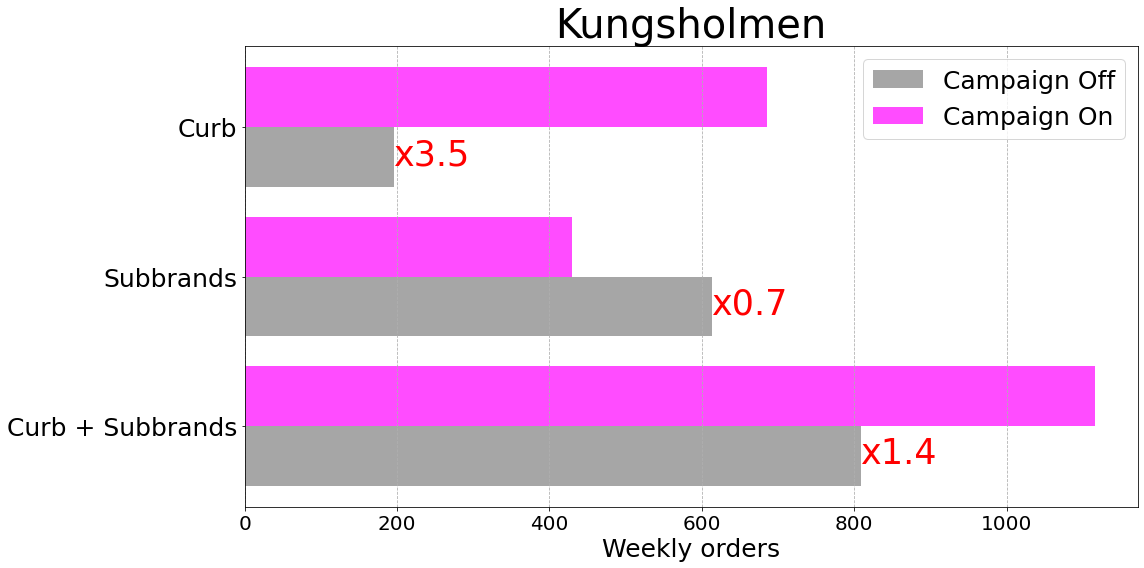

In [269]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))

cols = ['Curb + Subbrands', 'Subbrands', 'Curb']
plt.barh(np.arange(0, 6, 2), [809, 613, 196], color='grey', alpha=0.7, label='Campaign Off')
plt.barh(np.arange(0, 6, 2)+0.8, [1116, 430, 686], color='magenta', alpha=0.7, label='Campaign On')
plt.yticks(np.arange(0, 3 * 2, 2)+0.4, cols, fontsize=25, rotation=0)

uplift = [1.4, 0.7, 3.5]
for i, v in enumerate(uplift):
    v = round(v, 1)
    plt.text(x=[809, 613, 196][i], y=np.arange(0, 6, 2)[i]-0.1, s='x' + str(v), fontsize=35, color='r')


plt.xticks(fontsize=20, rotation=0)
plt.grid(axis='x', ls='--')
plt.legend(fontsize=25)

plt.xlabel("Weekly orders", fontsize=25)

plt.title(f"Kungsholmen", fontsize=40)
plt.tight_layout()


In [401]:
df = pd.read_csv('weekly_sales.csv')

In [402]:
df.location

0                   Mörby
1                   Mörby
2                   Mörby
3                   Mörby
4                   Mörby
             ...         
73    Copenhagen Nordvest
74    Copenhagen Nordvest
75    Copenhagen Nordvest
76    Copenhagen Nordvest
77    Copenhagen Nordvest
Name: location, Length: 78, dtype: object

In [403]:
df.head()

,location,Yearweek,Orders,% Increase
0,Mörby,"Jun 20, 2022",323,0.281746
1,Mörby,"May 2, 2022",175,-0.248927
2,Mörby,"May 30, 2022",240,-0.175258
3,Mörby,"May 16, 2022",215,0.096939
4,Mörby,"Jun 6, 2022",233,-0.029167


In [404]:
import seaborn as sns

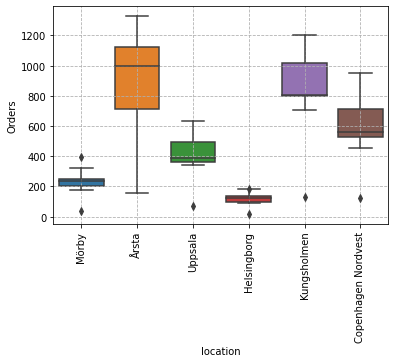

In [405]:
sns.boxplot(x='location', y='Orders', data=df)
plt.xticks(rotation=90)
plt.grid(ls='--')

In [384]:
df = df.groupby('location')['Orders'].mean().reset_index()


In [385]:
df['monthly_orders'] = (df.Orders * 30/7).astype('int')
df['monthly_orders_july'] = (df.monthly_orders * 0.83).astype('int')

In [386]:
df.sort_values(by='monthly_orders', ascending=False)

,location,Orders,monthly_orders,monthly_orders_july
5,Årsta,889.923077,3813,3164
2,Kungsholmen,845.153846,3622,3006
0,Copenhagen Nordvest,592.615385,2539,2107
4,Uppsala,411.538462,1763,1463
3,Mörby,231.538462,992,823
1,Helsingborg,118.461538,507,420
